In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [2]:
healt_cost = pd.read_csv('/Users/sebaguerraty-macbook/Github/Aux-IN6531-/Aux Modelos predictivos/insurance.csv')

In [3]:
healt_cost.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
healt_cost.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
healt_cost['region'].astype('category').cat.categories

Index(['northeast', 'northwest', 'southeast', 'southwest'], dtype='object')

In [6]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_region = pd.DataFrame(enc.fit_transform(healt_cost[['region']]).toarray(), columns= healt_cost['region'].astype('category').cat.categories)
enc_region.head()

,northeast,northwest,southeast,southwest
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [7]:
sex_and_smoker_dummies = pd.get_dummies(healt_cost, columns=['sex','smoker'], prefix_sep='_',)

In [8]:
sex_and_smoker_dummies.head()

,age,bmi,children,region,charges,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.900,0,southwest,16884.92400,1,0,0,1
1,18,33.770,1,southeast,1725.55230,0,1,1,0
2,28,33.000,3,southeast,4449.46200,0,1,1,0
3,33,22.705,0,northwest,21984.47061,0,1,1,0
4,32,28.880,0,northwest,3866.85520,0,1,1,0


In [9]:
health_cost = sex_and_smoker_dummies.join(enc_region)

In [13]:
health_cost.drop(columns=['region'], inplace=True)

In [14]:
health_cost.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,northeast,northwest,southeast,southwest
0,19,27.900,0,16884.92400,1,0,0,1,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,0,1,1,0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,0,1,1,0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,0,1,1,0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,0,1,1,0,0.0,1.0,0.0,0.0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(health_cost.drop(columns='charges'),health_cost['charges'], test_size = 0.2, random_state = 12345)

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, cross_validate

In [60]:
#definicion del modelo a utulizar (segun libreria sklearn)
model = LinearRegression()

#entregar los datos de entrenamiento para el modelo definido
model.fit(X_train,y_train)

#obtener los valores estimados para el modelo
predictions_in_sample = model.predict(X_train)
predictions_out_of_sample = model.predict(X_test)


#train metrics
Error_absoluto_medio_entrenamiento_MAE_ = mean_absolute_error(y_pred= predictions_in_sample, y_true= y_train) 
Error_porcentual_medio_entrenamiento_MAPE = np.mean(np.abs((y_train - predictions_in_sample) / y_train)) * 100
Error_cuaratico_medio_entrenamiento_RMSE = np.sqrt(mean_squared_error(y_pred=predictions_in_sample, y_true= y_train))

#test metrics
Error_absoluto_medio_validacion_MAE = mean_absolute_error(y_pred= predictions_out_of_sample, y_true= y_test) 
Error_porcentual_medio_validacion_MAPE = np.mean(np.abs((y_test - predictions_out_of_sample) / y_test)) * 100
Error_cuaratico_medio_validacion_RMSE = np.sqrt(mean_squared_error(y_pred=predictions_out_of_sample, y_true= y_test))

print(('Error absoluto dentro de muestra: {}').format(Error_absoluto_medio_entrenamiento_MAE_))
print(('Error porcentual dentro de muestra: {}').format(Error_porcentual_medio_entrenamiento_MAPE))
print(('Error cuadratico dentro de muestra: {}').format(Error_cuaratico_medio_entrenamiento_RMSE))
print(' ')
print(('Error absoluto fuera de muestra: {}').format(Error_absoluto_medio_validacion_MAE))
print(('Error porcentual fuera de muestra: {}').format(Error_porcentual_medio_validacion_MAPE))
print(('Error cuadratico fuera de muestra: {}').format(Error_cuaratico_medio_validacion_RMSE))


Error absoluto dentro de muestra: 4207.115438736581
Error porcentual dentro de muestra: 41.35522526367165
Error cuadratico dentro de muestra: 6098.183309825992
 
Error absoluto fuera de muestra: 3919.5358466936264
Error porcentual fuera de muestra: 37.76120575583558
Error cuadratico fuera de muestra: 5847.447867222494


In [88]:
def kfoldize(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test

https://towardsdatascience.com/complete-guide-to-pythons-cross-validation-with-examples-a9676b5cac12


<img src="https://miro.medium.com/max/700/1*vAzt64N5yJNOwn5DEGXWjg.jpeg">

In [93]:
#version manual
kf5 = KFold(n_splits= 5, shuffle=True)

for train_index, test_index in kf5.split(healt_cost):
    X_train_cv = health_cost.iloc[train_index].drop(columns='charges')
    X_test_cv = health_cost.iloc[test_index].drop(columns='charges')
    y_train_cv = health_cost.iloc[train_index].loc[:,'charges']
    y_test_cv = health_cost.loc[test_index]['charges']

    model.fit(X_train_cv, y_train_cv) #Training the model
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test_cv, model.predict(X_test_cv))}")
    i += 1


In [104]:
reg_model = LinearRegression()

for i,score in enumerate(cross_validate( reg_model, health_cost.drop(columns='charges'), health_cost.loc[:,'charges'], scoring=['neg_mean_absolute_error'] , cv=5)['test_neg_mean_absolute_error']):
    print(f'MAE for the fold N {i} on the test: {score}')

MAE for the fold N 0 on the test: -4239.552402652572
MAE for the fold N 1 on the test: -4260.806915295988
MAE for the fold N 2 on the test: -4015.7734548676162
MAE for the fold N 3 on the test: -4256.1702402024985
MAE for the fold N 4 on the test: -4216.31183932583


In [63]:
help(LinearRegression)

Help on class LinearRegression in module sklearn.linear_model._base:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  LinearRegression(*, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, default=True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  normalize : bool, default=False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean 

<h3>Y ese error da lo mismo como se ve? </h3>

In [70]:
from scipy.stats import probplot
import matplotlib as plt

In [71]:
train_errors = y_train - predictions_in_sample
test_errors = y_test - predictions_out_of_sample

<AxesSubplot:xlabel='charges', ylabel='Density'>

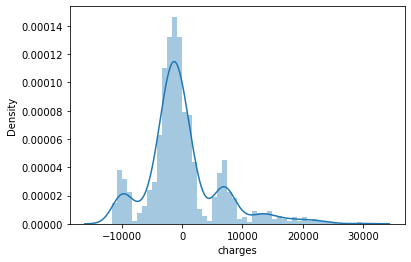

In [73]:
# train errors dist
sns.distplot(train_errors)

((array([-3.21704504, -2.9533172 , -2.80624164, ...,  2.80624164,
          2.9533172 ,  3.21704504]),
  array([-11617.68309971, -11563.19764445, -11550.49724197, ...,
          24137.59051351,  24989.18079651,  29837.11430287])),
 (5794.825389022226, -2.993232266662942e-12, 0.947765873023043))

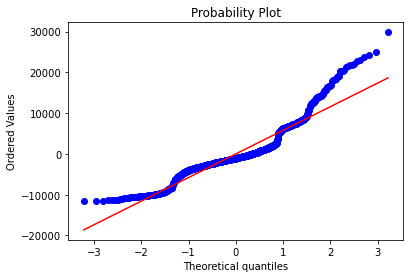

In [74]:
probplot(train_errors, dist="norm", plot=plt.pyplot)

Tipico ejemplo de distribución con "colas gordas" 

Como se ve algo que tiene una distribucion normal más apegada a la teoría

<img src="https://miro.medium.com/max/808/1*JjBKqmoJyZSfnmTROqhfog.png">

más sobre Q-Q plots: https://towardsdatascience.com/q-q-plots-explained-5aa8495426c0

<AxesSubplot:xlabel='charges', ylabel='Density'>

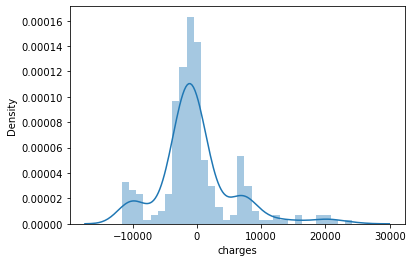

In [67]:
#test error dist
sns.distplot(test_errors)

((array([-2.79649277, -2.4966039 , -2.32650869, -2.20514436, -2.10955733,
         -2.03007379, -1.96166434, -1.90136582, -1.84727945, -1.79811247,
         -1.7529434 , -1.7110913 , -1.67203817, -1.63538038, -1.60079708,
         -1.56802882, -1.53686267, -1.50712165, -1.47865698, -1.45134236,
         -1.42506958, -1.39974522, -1.37528804, -1.3516269 , -1.32869918,
         -1.30644941, -1.28482825, -1.26379157, -1.24329979, -1.22331718,
         -1.20381147, -1.18475332, -1.16611605, -1.14787525, -1.1300086 ,
         -1.11249556, -1.09531724, -1.07845621, -1.06189633, -1.04562265,
         -1.02962128, -1.01387928, -0.99838461, -0.98312599, -0.96809291,
         -0.95327549, -0.93866447, -0.92425113, -0.91002729, -0.89598523,
         -0.88211765, -0.86841767, -0.85487877, -0.8414948 , -0.82825989,
         -0.81516849, -0.80221533, -0.7893954 , -0.77670391, -0.76413631,
         -0.75168825, -0.73935561, -0.7271344 , -0.71502084, -0.70301131,
         -0.69110233, -0.67929056, -0.

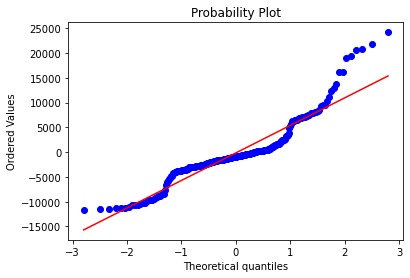

In [75]:
probplot(test_errors, dist="norm", plot=plt.pyplot)

<h2> Preguntas ? </h2>

<b>Probar varios modelos distintos con poco codigo y POO/OOP</b>

In [17]:
# Modelos
models = []
models.append(LinearRegression())
models.append(KNeighborsRegressor())
models.append(DecisionTreeRegressor())
models.append(RandomForestRegressor(random_state=10))
models.append(SVR())
#Names
names=[]
names.append('Reg Lineal')
names.append('KNN')
names.append('D Tree')
names.append('Random Forest')
names.append('SVM')

In [20]:
train_MAE=[]
train_RMSE=[]
test_MAE=[]
test_RMSE=[]

for model in models:
  #Ajuste
  model.fit(X_train, y_train)
  
  # Train preditc
  y_pred=model.predict(X_train)  
  #Métricas
  RMSE=np.sqrt(mean_squared_error(y_train, y_pred))
  MAE=mean_absolute_error(y_train, y_pred)
  
  
  train_MAE.append(MAE)
  train_RMSE.append(RMSE)
  
  
  #Test predict
  y_pred=model.predict(X_test) 
  #Métricas
  RMSE=np.sqrt(mean_squared_error(y_test, y_pred))
  MAE=mean_absolute_error(y_test, y_pred)
  
  test_MAE.append(MAE)
  test_RMSE.append(RMSE)
  

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

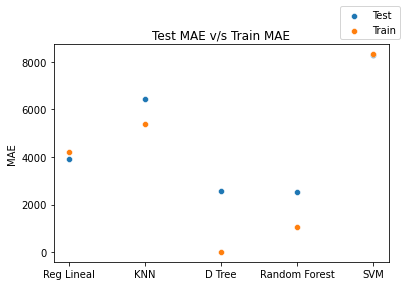

In [37]:
sns.scatterplot(names, test_MAE, label='Test')
sns.scatterplot(names, train_MAE, label='Train')
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
plt.title('Test MAE v/s Train MAE')
plt.ylabel('MAE')
plt.show()

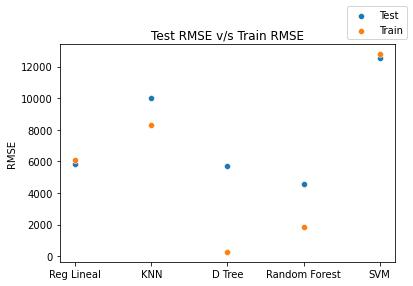

In [38]:
sns.scatterplot(names, test_RMSE, label='Test')
sns.scatterplot(names, train_RMSE, label='Train')
plt.legend(loc='lower right', bbox_to_anchor=(1.05, 1))
plt.title('Test RMSE v/s Train RMSE')
plt.ylabel('RMSE')
plt.show()

<h3> Qué modelo es mejor? </h3>


<h3> De qué depende? </h3>

In [41]:
help(LinearRegression)

Help on class LinearRegression in module sklearn.linear_model._base:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  LinearRegression(*, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, default=True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  normalize : bool, default=False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean 

In [42]:
help(KNeighborsRegressor)

Help on class KNeighborsRegressor in module sklearn.neighbors._regression:

class KNeighborsRegressor(sklearn.neighbors._base.NeighborsBase, sklearn.neighbors._base.KNeighborsMixin, sklearn.neighbors._base.SupervisedFloatMixin, sklearn.base.RegressorMixin)
 |  KNeighborsRegressor(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs)
 |  
 |  Regression based on k-nearest neighbors.
 |  
 |  The target is predicted by local interpolation of the targets
 |  associated of the nearest neighbors in the training set.
 |  
 |  Read more in the :ref:`User Guide <regression>`.
 |  
 |  .. versionadded:: 0.9
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'} or callable, default='uniform'
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : un

In [43]:
help(DecisionTreeRegressor)

re for potential splits,
 |      and "mae" for the mean absolute error, which minimizes the L1 loss
 |      using the median of each terminal node.
 |  
 |      .. versionadded:: 0.18
 |         Mean Absolute Error (MAE) criterion.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int, default=None
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int or float, default=2
 |      The minimum number of samples required to split an internal node:
 |  
 |      - If int, then consider `min_samples_split` as the minimum number.
 |      - If float, then `min_samples_split` is a fraction and
 |        `ceil(min_samples_split * n_samples)

In [44]:
help(RandomForestRegressor)

estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and uses averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : int, default=100
 |      The number of trees in the forest.
 |  
 |      .. versionchanged:: 0.22
 |         The default value of ``n_estimators`` changed from 10 to 100
 |         in 0.22.
 |  
 |  criterion : {"mse", "mae"}, default="mse"
 |      The function to measure the quality of a split. Supported criteria
 |      are "mse" for the mean squared error, which is equal to variance
 |      reduction as feature selection criterion, and "mae" for the mean
 |      absolute error.
 |  
 |      .. versionadded:: 0.18
 |         Mean Abs

In [45]:
help(SVR)

Help on class SVR in module sklearn.svm._classes:

class SVR(sklearn.base.RegressorMixin, sklearn.svm._base.BaseLibSVM)
 |  SVR(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
 |  
 |  Epsilon-Support Vector Regression.
 |  
 |  The free parameters in the model are C and epsilon.
 |  
 |  The implementation is based on libsvm. The fit time complexity
 |  is more than quadratic with the number of samples which makes it hard
 |  to scale to datasets with more than a couple of 10000 samples. For large
 |  datasets consider using :class:`sklearn.svm.LinearSVR` or
 |  :class:`sklearn.linear_model.SGDRegressor` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  Read more in the :ref:`User Guide <svm_regression>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
 |       Specifies the k

Versión de TensorFlow: https://www.tensorflow.org/tutorials/keras/regression



In [77]:
MAE_SVM = []
RMSE_SVM = []
MSE_SVM = []

for c in range(1, 30):
  #Ajuste para un C variable
  model = SVR(kernel = 'linear', C = c)
  model.fit(X_train, y_train)
  
  #predecir
  y_pred=model.predict(X_test) 
  
  #errores
  RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
  MAE = mean_absolute_error(y_test, y_pred)

  
  #Guardar datos
  MAE_SVM.append(MAE)
  RMSE_SVM.append(RMSE)

Text(0.5, 0, 'C')

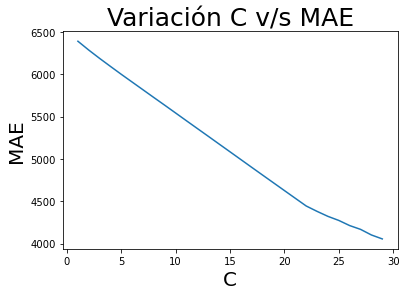

In [84]:
sns.lineplot(np.arange(1,30), MAE_SVM)
plt.title('Variación C v/s MAE', size = 25)
plt.ylabel('MAE', size = 20)
plt.xlabel('C', size = 20)

Text(0.5, 0, 'C')

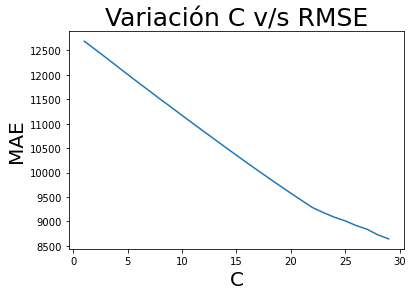

In [85]:
sns.lineplot(np.arange(1,30), RMSE_SVM)
plt.title('Variación C v/s RMSE', size = 25)
plt.ylabel('MAE', size = 20)
plt.xlabel('C', size = 20)

C equivale a una hiperparametro responsable de penalizar el error (diferencia entre prediccion y valor real) 